# Ecommerce Notebook

## Objectives 
Aims to analyse and transform an e-commerce dataset by performing data cleaning, feature engineering, and clustering. Key objectives include identifying and removing anomalies in transaction data, creating new features such as customer expenditure, and implementing clustering algorithms to segment customers based on their purchasing behaviour. The overall goal is to gain information from customer data, which can be used for improved marketing strategies.

### Cluster Summaries for Marketing Department

**Group 1**:  
These are **light, infrequent shoppers**. They typically make a single purchase with small quantities and lower spending per item. Their purchases mostly include basic home and living items, along with some interest in furniture and decor. Marketing could target them with promotions on frequently bought essentials to encourage repeat visits.

**Group 2**:  
This group consists of **loyal, high-frequency buyers**. They make numerous purchases and spend moderately, often buying in bulk. They favour home and living items but also buy party supplies and furniture. Marketing strategies can focus on loyalty rewards and exclusive offers to retain and increase their spending.

**Group 3**:  
These are **occasional buyers with mid-range spending**. They make fewer transactions than Group 2 but purchase moderate quantities across diverse categories. They are interested in lower-priced items, especially home essentials. Marketing could focus on bundle deals or seasonal discounts to boost their purchase frequency.

**Group 4**:  
This small group represents **bulk buyers** or possibly **resellers**. They make large transactions, purchasing vast quantities mainly in home and living items, with high total expenditure. Marketing could consider wholesale offers or volume discounts to cater to their bulk purchasing needs.

# Libraries and options

In [132]:
# libraries
import pandas as pd
import numpy as np
import re
import seaborn as sns
import pandas as pd
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import plotly.express as px
from feature_engine import encoding, imputation
from sklearn import base, pipeline
from sklearn.preprocessing import StandardScaler
import umap

# Folders organization
RootFolderPath = '/Users/ric_carollo/Works/E-Commerce'
DataFolder = RootFolderPath + '/Data'
ExportsFolder = RootFolderPath + '/Exports'

# Projects global options
pd.set_option('display.max_rows', 500)

# Import dataframe

In [133]:
# read the data set
df = pd.read_csv(DataFolder+'/dataOriginal.csv',encoding="ISO-8859-1",
                         dtype={'CustomerID': str,'InvoiceID': str})

df_nlp = pd.read_csv(DataFolder+'/ArticlesShoppingCat.csv',encoding="ISO-8859-1")

# convert to date time
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# General info on the dataset

In [134]:
# print the shape
print('Dataframe dimensions:', df.shape)

Dataframe dimensions: (541909, 8)


In [135]:
df_nlp.head()

,Description,AssignedCategory
0,WHITE HANGING HEART T-LIGHT HOLDER,Home and Living
1,WHITE METAL LANTERN,Home and Living
2,CREAM CUPID HEARTS COAT HANGER,Furniture and Decor
3,KNITTED UNION FLAG HOT WATER BOTTLE,Home and Living
4,RED WOOLLY HOTTIE WHITE HEART.,Clothing and accessories


In [136]:
# Get data types of each column
data_types = df.dtypes

# Get missing values for each column
missing_values = df.isna().sum()

print("Data Types:")
print(data_types)
print("\n")
print("Missing Values:")
print(missing_values)

Data Types:
InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
dtype: object


Missing Values:
InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


In [137]:
df.head(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


# Data cleaning

In [138]:
def clean_df(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply a series of feature-engineering, filtering, and transformation functions to the input DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing stock data.
    
    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with filtered values and adjusted columns.
    """
    return (df
            .pipe(lambda df: df[df['StockCode'].str.match(r'^\d{5}[A-Za-z]{0,2}$')])  # Filter StockCode with specific pattern
            .pipe(lambda df: df[df['Quantity'] > 0])  # Filter rows with positive Quantity
            .pipe(lambda df: df.assign(z_scores_quantity = np.abs((df['Quantity'] - np.mean(df['Quantity'])) / np.std(df['Quantity']))))  # Calculate z-scores for Quantity
            .pipe(lambda df: df[df['z_scores_quantity'] <= 3].drop(columns='z_scores_quantity'))  # Filter based on z-scores for Quantity
            .pipe(lambda df: df[df['UnitPrice'] > 0])  # Filter rows with positive UnitPrice
            .pipe(lambda df: df.assign(z_scores_price = np.abs((df['UnitPrice'] - np.mean(df['UnitPrice'])) / np.std(df['UnitPrice']))))  # Calculate z-scores for UnitPrice
            .pipe(lambda df: df[df['z_scores_price'] <= 3].drop(columns='z_scores_price'))  # Filter based on z-scores for UnitPrice
            .pipe(lambda df: df.assign(InvoiceDate=df.groupby('InvoiceNo')['InvoiceDate'].transform('min')))  # Set InvoiceDate to the minimum per InvoiceNo
            .assign(Expenditure = lambda df: df['Quantity'] * df['UnitPrice'])
            .merge(df_nlp, on='Description', how='inner')  # Merge df_cleaned_4 with df_nlp on 'Description'
            .drop('Country', axis = 1)
           )

# Transforming the dataframe

In [139]:
def user_num_transactions(df): 
    return pd.DataFrame(df.groupby('CustomerID').nunique('InvoiceNo')['InvoiceNo'].rename('NumUniqueTransactions'))

def user_num_purchases(df): 
    return pd.DataFrame(df.groupby('CustomerID')['InvoiceNo'].count().rename('NumPurchases'))

def average_calculation(df, features): 
    return pd.DataFrame(df.groupby('CustomerID')[features].mean().rename(columns=lambda x: f'Avg_{x}'))

def std_calculation(df, features): 
    return pd.DataFrame(df.groupby('CustomerID')[features].std().fillna(999).rename(columns=lambda x: f'Std_{x}'))

def category_frequency(df, features):
    return pd.DataFrame(df.groupby('CustomerID')[features].sum().rename(columns=lambda x: f'Sum_{x}'))

def average_time_distance(df):
    time_diff = df.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].mean().reset_index()
    time_diff['TimeDelta'] = time_diff.groupby('CustomerID')['InvoiceDate'].diff()
    return pd.DataFrame(time_diff.groupby('CustomerID')['TimeDelta'].mean().fillna(pd.to_timedelta(730, unit='D')).dt.days.rename('AvgTimeDistance'))

def std_time_distance(df):
    time_diff = df.groupby(['CustomerID', 'InvoiceNo'])['InvoiceDate'].mean().reset_index()
    time_diff['TimeDelta'] = time_diff.groupby('CustomerID')['InvoiceDate'].diff().dt.total_seconds() / (24 * 60 * 60)
    std_deviation = time_diff.groupby('CustomerID')['TimeDelta'].std()
    return pd.DataFrame(pd.to_timedelta(std_deviation, unit='D').dt.days.fillna(999).rename('StdTimeDistance'))

def transform_df(df): 
    """
    Apply a series of transformation functions to the input DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing customer transaction data, including columns such as 'CustomerID', 
        'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice', 'Expenditure', and categorical features 
        (e.g., 'Assigned' and 'Country').
    
    Returns
    -------
    pd.DataFrame
        The transformed DataFrame with aggregated transaction statistics per customer, such as the number 
        of unique transactions, average and standard deviation of quantities, prices, expenditures, 
        category frequency sums, and time distance metrics. Only customers with more than three purchases 
        are included in the output.
    """
    return (user_num_transactions(df)
            .merge(user_num_purchases(df), on='CustomerID')
            .merge(average_calculation(df, ['Quantity', 'UnitPrice', 'Expenditure']), on='CustomerID')
            .merge(std_calculation(df, ['Quantity', 'UnitPrice', 'Expenditure']), on='CustomerID')
            .merge(average_time_distance(df), on='CustomerID')
            .merge(std_time_distance(df), on='CustomerID')
            .merge(category_frequency(df, df.filter(like='Assigned').columns.tolist() + df.filter(like='Country').columns.tolist()), on='CustomerID')
            .pipe(lambda df: df[df['NumPurchases'] > 3])
           )


In [140]:
class CleanDfTransformer(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return clean_df(X)

    def fit(self, X, y=None): 
        return self


In [141]:
class TransformDfTransformer(base.BaseEstimator, base.TransformerMixin): 
    def __init__(self, ycol=None): 
        self.ycol = ycol

    def transform(self, X): 
        return transform_df(X)

    def fit(self, X, y=None): 
        return self


In [142]:
df_pl_pre = pipeline.Pipeline([
    ('clean', CleanDfTransformer(df_nlp)), 
    ('cat', encoding.OneHotEncoder(variables=["AssignedCategory"], top_categories = 5)),
    ('transform', TransformDfTransformer()),
])

In [143]:
df_transformed = df_pl_pre.fit_transform(df)

In [144]:
df_transformed.head()

,NumUniqueTransactions,NumPurchases,Avg_Quantity,Avg_UnitPrice,Avg_Expenditure,Std_Quantity,Std_UnitPrice,Std_Expenditure,AvgTimeDistance,StdTimeDistance,Sum_AssignedCategory_Home and Living,Sum_AssignedCategory_Furniture and Decor,Sum_AssignedCategory_Party and Celebration Supplies,Sum_AssignedCategory_Toys and Games,Sum_AssignedCategory_Cookware and Kitchen Essentials
CustomerID,,,,,,,,,,,,,,,
12347,7,182,13.505495,2.644011,23.681319,18.856172,2.255381,23.289902,60,18.0,48,20,12,20,34
12348,4,27,86.370370,0.692963,53.231111,45.421232,0.408042,37.159075,94,69.0,0,0,13,2,2
12349,1,71,8.859155,3.734507,19.966197,6.959671,3.318293,11.268834,730,999.0,25,7,4,0,14
12350,1,16,12.250000,1.581250,18.400000,3.492850,0.578756,5.214211,730,999.0,4,2,0,1,0
12352,7,77,6.831169,4.075455,17.996623,4.338938,2.892164,4.893414,43,68.0,17,9,3,19,20


In [145]:
df_pl_cluster = pipeline.Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_init = 'auto'))
])

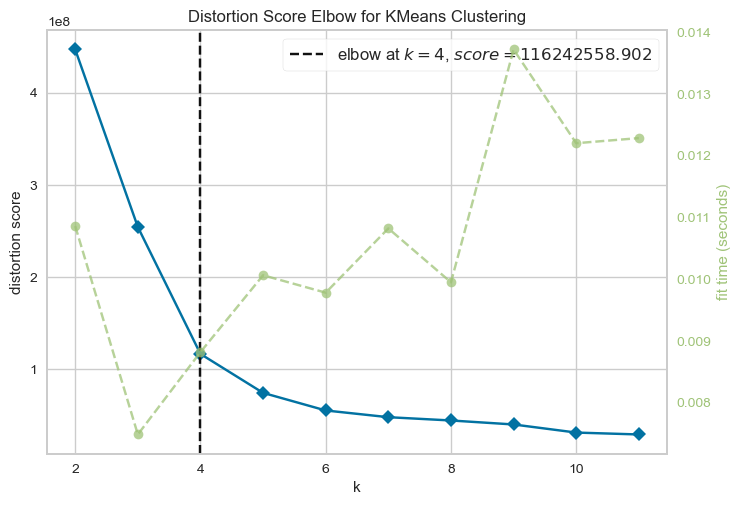

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [146]:
df_pl_cluster.fit(df_transformed)

# Use the KElbowVisualizer with the pipeline applied
visualizer = KElbowVisualizer(df_pl_cluster.named_steps['kmeans'], k=(2, 12))
visualizer.fit(df_transformed)
visualizer.show()


In [147]:
df_pl_cluster = pipeline.Pipeline([
    ('scaler', StandardScaler()),
    ('kmeans', KMeans(n_init = 'auto', n_clusters = 4))
])

In [148]:
df_transformed['Cluster_Label'] = df_pl_cluster.fit_predict(df_transformed)

/Users/ric_carollo/opt/anaconda3/envs/taxi_project/lib/python3.11/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


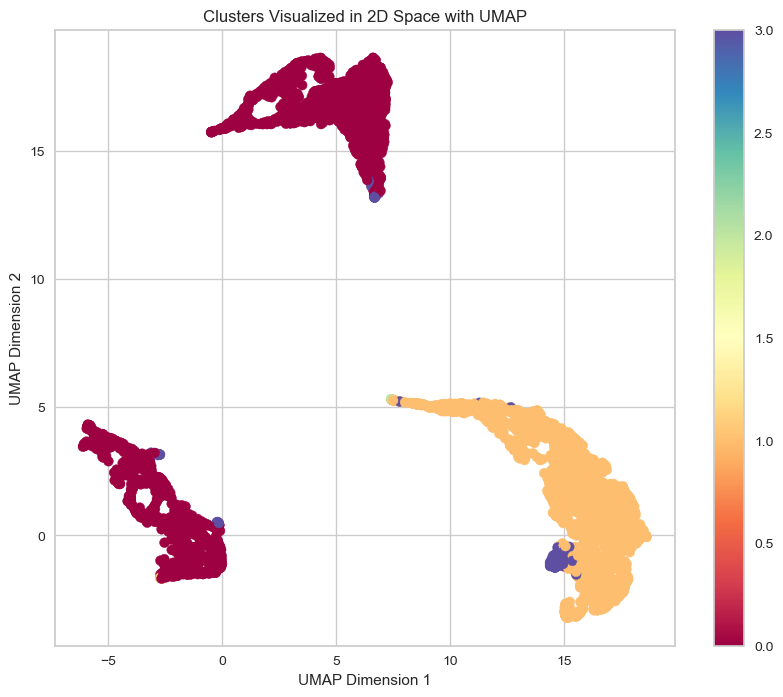

In [149]:
def umap_cluster_plot(df, random_state=42):
    # Reduce dimensionality with UMAP
    umap_reducer = umap.UMAP(n_components=2, random_state=random_state)
    df_umap = umap_reducer.fit_transform(df)

    # Get cluster labels
    labels = df['Cluster_Label']

    # Plot the clusters
    plt.figure(figsize=(10, 8))
    plt.scatter(df_umap[:, 0], df_umap[:, 1], c=labels, cmap='Spectral', s=50)
    plt.title('Clusters Visualized in 2D Space with UMAP')
    plt.xlabel('UMAP Dimension 1')
    plt.ylabel('UMAP Dimension 2')
    plt.colorbar()
    plt.show()

umap_cluster_plot(df_transformed)

In [150]:
df_transformed['Cluster_Label'].value_counts()

Cluster_Label
0    2128
1    1889
3     119
2       4
Name: count, dtype: int64

In [157]:
df_transformed.groupby('Cluster_Label').mean()

,NumUniqueTransactions,NumPurchases,Avg_Quantity,Avg_UnitPrice,Avg_Expenditure,Std_Quantity,Std_UnitPrice,Std_Expenditure,AvgTimeDistance,StdTimeDistance,Sum_AssignedCategory_Home and Living,Sum_AssignedCategory_Furniture and Decor,Sum_AssignedCategory_Party and Celebration Supplies,Sum_AssignedCategory_Toys and Games,Sum_AssignedCategory_Cookware and Kitchen Essentials
Cluster_Label,,,,,,,,,,,,,,,
0,1.373120,31.883459,10.917949,2.962378,18.611379,9.374893,2.356781,12.098148,500.701128,999.000000,8.034305,4.277256,3.745771,3.359023,3.026786
1,6.976707,153.757544,11.754887,2.862531,20.580849,11.828229,2.387002,16.598313,56.418211,43.888301,40.901006,21.805188,16.617787,15.440445,15.107464
2,136.000000,5712.750000,6.505882,2.910810,11.530515,12.536190,2.615296,17.939813,2.750000,2.000000,1486.250000,846.750000,599.500000,526.000000,514.500000
3,11.806723,103.210084,101.157786,2.656411,176.527257,75.664422,1.830390,143.316542,146.504202,298.126050,26.621849,13.714286,12.100840,10.857143,13.722689
